# MBTI Predict

In [1]:
pip show pyspark

Name: pyspark
Version: 3.5.1
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: c:\users\lenovo\appdata\local\programs\python\python310\lib\site-packages
Requires: py4j
Required-by: apache-airflow-providers-apache-spark
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyspark.sql import SparkSession

In [2]:
import os
print(os.environ.get("JAVA_HOME"))

C:\Program Files\Java\jdk-11


In [3]:
import pyspark
print("PySpark Version:", pyspark.__version__)

PySpark Version: 3.5.1


In [4]:
spark = SparkSession.builder \
    .appName("MBTI Loader") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.driver.maxResultSize", "6g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

print("Spark is alive:", spark.version)

Spark is alive: 3.5.5


In [37]:
spark

### Data Merging

In [ ]:
df1 = spark.read.csv("hdfs://localhost:9000/mbti-dataset/mbti_1.csv", header=True, inferSchema=True)
df1.show(5)

In [ ]:
df2 = spark.read.csv("hdfs://localhost:9000/mbti-dataset/mbti_2.csv", header=True, inferSchema=True)
df2.show(5)

In [ ]:
df2_sample = df2.limit(100)

In [ ]:
df2 = df2.select("type", "posts")

In [ ]:
df2_sample = df2.sample(fraction=0.1, seed=42)
df_combined = df1.unionByName(df2_sample)

In [ ]:
# Simpan ke Lokal
df_combined.coalesce(1) \
    .write \
    .mode("overwrite") \
    .option("header", True) \
    .csv("/home/nadiukira/Downloads/mbti_combined.csv")

In [ ]:
# Simpan ke HDFS
df_combined.coalesce(1) \
    .write \
    .mode("overwrite") \
    .option("header", True) \
    .csv("hdfs://localhost:9000/mbti-dataset/mbti_combined.csv")

### Data Preparation

In [ ]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder.appName("MBTI Loader").getOrCreate()

abs_path = os.path.abspath("mbti_combined.csv")
spark_path = "file:///" + abs_path.replace("\\", "/")

try:
    data = spark.read.csv(
        spark_path,
        header=True,
        inferSchema=True,
        multiLine=True,
        quote="\"",
        escape="\""
    )
    data.show(5)
except Exception as e:
    print("Gagal baca file:", e)

+----+--------------------+
|type|               posts|
+----+--------------------+
|INFJ|'http://www.youtu...|
|ENTP|'I'm finding the ...|
|INTP|'Good one  _____ ...|
|INTJ|'Dear INTP,   I e...|
|ENTJ|'You're fired.|||...|
+----+--------------------+
only showing top 5 rows



In [9]:
data = data.withColumnRenamed('type','class').withColumnRenamed('posts','text')

In [10]:
data.show()

+-----+--------------------+
|class|                text|
+-----+--------------------+
| INFJ|'http://www.youtu...|
| ENTP|'I'm finding the ...|
| INTP|'Good one  _____ ...|
| INTJ|'Dear INTP,   I e...|
| ENTJ|'You're fired.|||...|
| INTJ|'18/37 @.@|||Scie...|
| INFJ|'No, I can't draw...|
| INTJ|'I tend to build ...|
| INFJ|I'm not sure, tha...|
| INTP|'https://www.yout...|
| INFJ|'One time my pare...|
| ENFJ|'https://www.yout...|
| INFJ|'Joe santagato - ...|
| INTJ|'Fair enough, if ...|
| INTP|'Basically this.....|
| INTP|'Your comment scr...|
| INFJ|'some of these bo...|
| INFP|'I think we do ag...|
| INFJ|'I fully believe ...|
| INFP|'That's normal, i...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import substring, length
for col, i in zip(["IE", "SN", "TF", "JP"], [1,2,3,4]):
    data = data.withColumn(col, substring("class", i, 1))

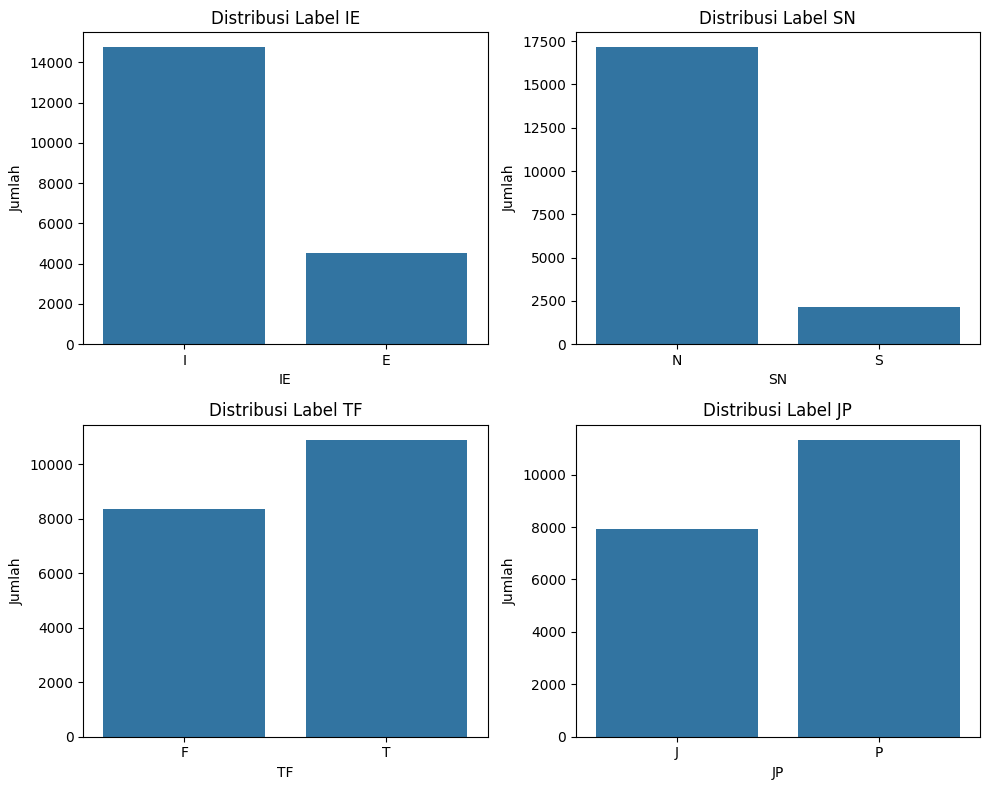

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pandas = data.select("IE", "SN", "TF", "JP").toPandas()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten() 

for i, col in enumerate(["IE", "SN", "TF", "JP"]):
    sns.countplot(x=col, data=df_pandas, ax=axes[i])
    axes[i].set_title(f"Distribusi Label {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Jumlah")

plt.tight_layout()
plt.show()

In [13]:
data = data.withColumn('length',length(data['text']))

In [14]:
data.show()

+-----+--------------------+---+---+---+---+------+
|class|                text| IE| SN| TF| JP|length|
+-----+--------------------+---+---+---+---+------+
| INFJ|'http://www.youtu...|  I|  N|  F|  J|  4652|
| ENTP|'I'm finding the ...|  E|  N|  T|  P|  7053|
| INTP|'Good one  _____ ...|  I|  N|  T|  P|  5265|
| INTJ|'Dear INTP,   I e...|  I|  N|  T|  J|  6271|
| ENTJ|'You're fired.|||...|  E|  N|  T|  J|  6111|
| INTJ|'18/37 @.@|||Scie...|  I|  N|  T|  J|  8589|
| INFJ|'No, I can't draw...|  I|  N|  F|  J|  7916|
| INTJ|'I tend to build ...|  I|  N|  T|  J|  6900|
| INFJ|I'm not sure, tha...|  I|  N|  F|  J|  5325|
| INTP|'https://www.yout...|  I|  N|  T|  P|  7573|
| INFJ|'One time my pare...|  I|  N|  F|  J|  8381|
| ENFJ|'https://www.yout...|  E|  N|  F|  J|  4724|
| INFJ|'Joe santagato - ...|  I|  N|  F|  J|  7007|
| INTJ|'Fair enough, if ...|  I|  N|  T|  J|  9035|
| INTP|'Basically this.....|  I|  N|  T|  P|  5291|
| INTP|'Your comment scr...|  I|  N|  T|  P|  7244|
| INFJ|'some

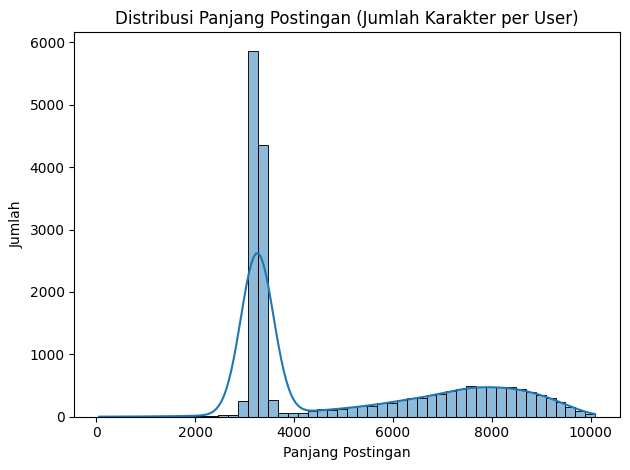

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

df_pandas = data.select("length", "IE", "SN", "TF", "JP").toPandas()

sns.histplot(data=df_pandas, x="length", bins=50, kde=True)
plt.title("Distribusi Panjang Postingan (Jumlah Karakter per User)")
plt.xlabel("Panjang Postingan")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

In [16]:
data.groupby('class').mean().show()

+-----+------------------+
|class|       avg(length)|
+-----+------------------+
| ENTJ| 4970.127102803738|
| ISFJ|6065.3516949152545|
| ESTJ| 5085.172839506173|
| ESFJ| 6417.327272727272|
| ENTP| 4687.296661193213|
| ISFP| 5875.311111111111|
| ESFP| 4714.033707865168|
| ENFJ| 5576.372093023256|
| ESTP|4369.6271777003485|
| INFJ| 5380.236860068259|
| INTJ| 4504.314393939394|
| INTP| 4637.917246920193|
| INFP| 5679.045841519319|
| ENFP| 5341.102386451116|
| ISTP| 5051.248175182482|
| ISTJ|5661.4390243902435|
+-----+------------------+



### Data Preprocessing and Feature Transformations

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
data = data.withColumn("idx", monotonically_increasing_id())

In [ ]:
from pyspark.sql.functions import regexp_replace, lower, col
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, VectorAssembler, StringIndexer

data = data.withColumn("cleaned_text", lower(col("text"))) 
data = data.withColumn("cleaned_text", regexp_replace("cleaned_text", "[^a-zA-Z\\s]", ""))  # hapus simbol, angka, dan karakter non-huruf

tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered")

vectorizer = CountVectorizer(inputCol="filtered", outputCol="vectorized")
idf = IDF(inputCol="vectorized", outputCol="tfidf")

assembler = VectorAssembler(inputCols=["tfidf"], outputCol="features")

### The Model

In [36]:
from pyspark.sql.functions import when, col
from pyspark.ml.classification import NaiveBayes, LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def compute_confusion_matrix(df):
    cm = df.groupBy("label", "prediction").count().toPandas()
    TP = TN = FP = FN = 0
    for _, row in cm.iterrows():
        true_label = int(row["label"])
        pred_label = int(row["prediction"])
        count = int(row["count"])
        if true_label == 1 and pred_label == 1:
            TP += count
        elif true_label == 0 and pred_label == 0:
            TN += count
        elif true_label == 0 and pred_label == 1:
            FP += count
        elif true_label == 1 and pred_label == 0:
            FN += count
    return (TP, TN, FP, FN)

def train_binary_classifier(label_col, model_type):
    indexer = StringIndexer(inputCol=label_col, outputCol="label")
    pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, idf, assembler, indexer])

    prepared = pipeline.fit(data).transform(data)
    train, test = prepared.randomSplit([0.7, 0.3], seed=42)

    if model_type == "naive_bayes":
        model = NaiveBayes(labelCol="label", featuresCol="features")
    elif model_type == "logistic_regression":
        model = LogisticRegression(labelCol="label", featuresCol="features")
    elif model_type == "random_forest":
        model = RandomForestClassifier(labelCol="label", featuresCol="features")
    else:
        raise ValueError("model_type harus 'naive_bayes', 'logistic_regression', atau 'random_forest'.")

    model_fit = model.fit(train)
    pred = model_fit.transform(test)

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    acc = evaluator.setMetricName("accuracy").evaluate(pred)
    prec = evaluator.setMetricName("weightedPrecision").evaluate(pred)
    recall = evaluator.setMetricName("weightedRecall").evaluate(pred)
    f1 = evaluator.setMetricName("f1").evaluate(pred)

    print(f"\nEvaluasi untuk dimensi {label_col} ({model_type}):")
    print(f"  Akurasi  : {acc:.4f}")
    print(f"  Presisi  : {prec:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1-Score : {f1:.4f}")

    pred_pd = pred.select("label", "prediction").toPandas()
    return pred_pd["label"].tolist(), pred_pd["prediction"].tolist()

def evaluate_model_confusion_matrix(model_type):
    all_y_true = []
    all_y_pred = []

    for dim in ["IE", "SN", "TF", "JP"]:
        y_true, y_pred = train_binary_classifier(dim, model_type)
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)

    plot_conf_matrix(all_y_true, all_y_pred, labels=[0.0, 1.0],
                     title=f"Total Confusion Matrix ({model_type.upper()})")

### Training and Evaluation

#### Naive Bayes


Evaluasi untuk dimensi IE (naive_bayes):
  Akurasi  : 0.7131
  Presisi  : 0.7654
  Recall   : 0.7131
  F1-Score : 0.7306

Evaluasi untuk dimensi SN (naive_bayes):
  Akurasi  : 0.7073
  Presisi  : 0.8703
  Recall   : 0.7073
  F1-Score : 0.7608

Evaluasi untuk dimensi TF (naive_bayes):
  Akurasi  : 0.6618
  Presisi  : 0.6627
  Recall   : 0.6618
  F1-Score : 0.6622

Evaluasi untuk dimensi JP (naive_bayes):
  Akurasi  : 0.6649
  Presisi  : 0.6900
  Recall   : 0.6649
  F1-Score : 0.6680


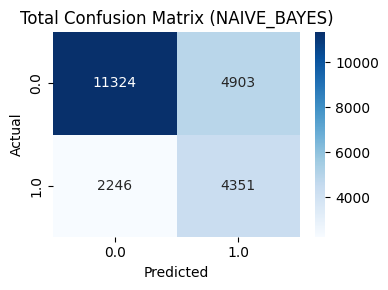

In [39]:
evaluate_model_confusion_matrix("naive_bayes")

#### Logistic Regression


Evaluasi untuk dimensi IE (logistic_regression):
  Akurasi  : 0.7517
  Presisi  : 0.7959
  Recall   : 0.7517
  F1-Score : 0.7660

Evaluasi untuk dimensi SN (logistic_regression):
  Akurasi  : 0.7976
  Presisi  : 0.8893
  Recall   : 0.7976
  F1-Score : 0.8289

Evaluasi untuk dimensi TF (logistic_regression):
  Akurasi  : 0.8127
  Presisi  : 0.8191
  Recall   : 0.8127
  F1-Score : 0.8137

Evaluasi untuk dimensi JP (logistic_regression):
  Akurasi  : 0.7119
  Presisi  : 0.7197
  Recall   : 0.7119
  F1-Score : 0.7140


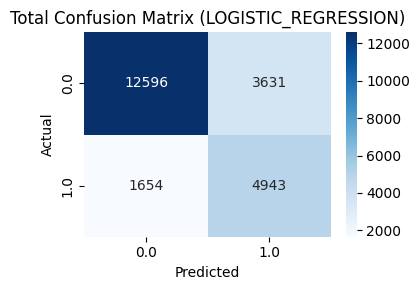

In [40]:
evaluate_model_confusion_matrix("logistic_regression")

#### Random Forest


Evaluasi untuk dimensi IE (random_forest):
  Akurasi  : 0.7746
  Presisi  : 0.6000
  Recall   : 0.7746
  F1-Score : 0.6762

Evaluasi untuk dimensi SN (random_forest):
  Akurasi  : 0.8919
  Presisi  : 0.7954
  Recall   : 0.8919
  F1-Score : 0.8409

Evaluasi untuk dimensi TF (random_forest):
  Akurasi  : 0.6374
  Presisi  : 0.7136
  Recall   : 0.6374
  F1-Score : 0.5571

Evaluasi untuk dimensi JP (random_forest):
  Akurasi  : 0.5980
  Presisi  : 0.7597
  Recall   : 0.5980
  F1-Score : 0.4479


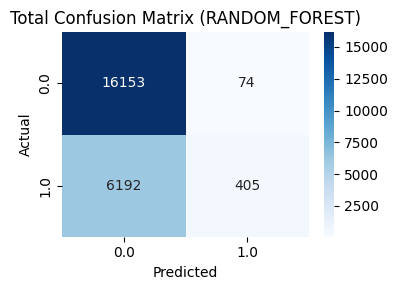

In [41]:
evaluate_model_confusion_matrix("random_forest")